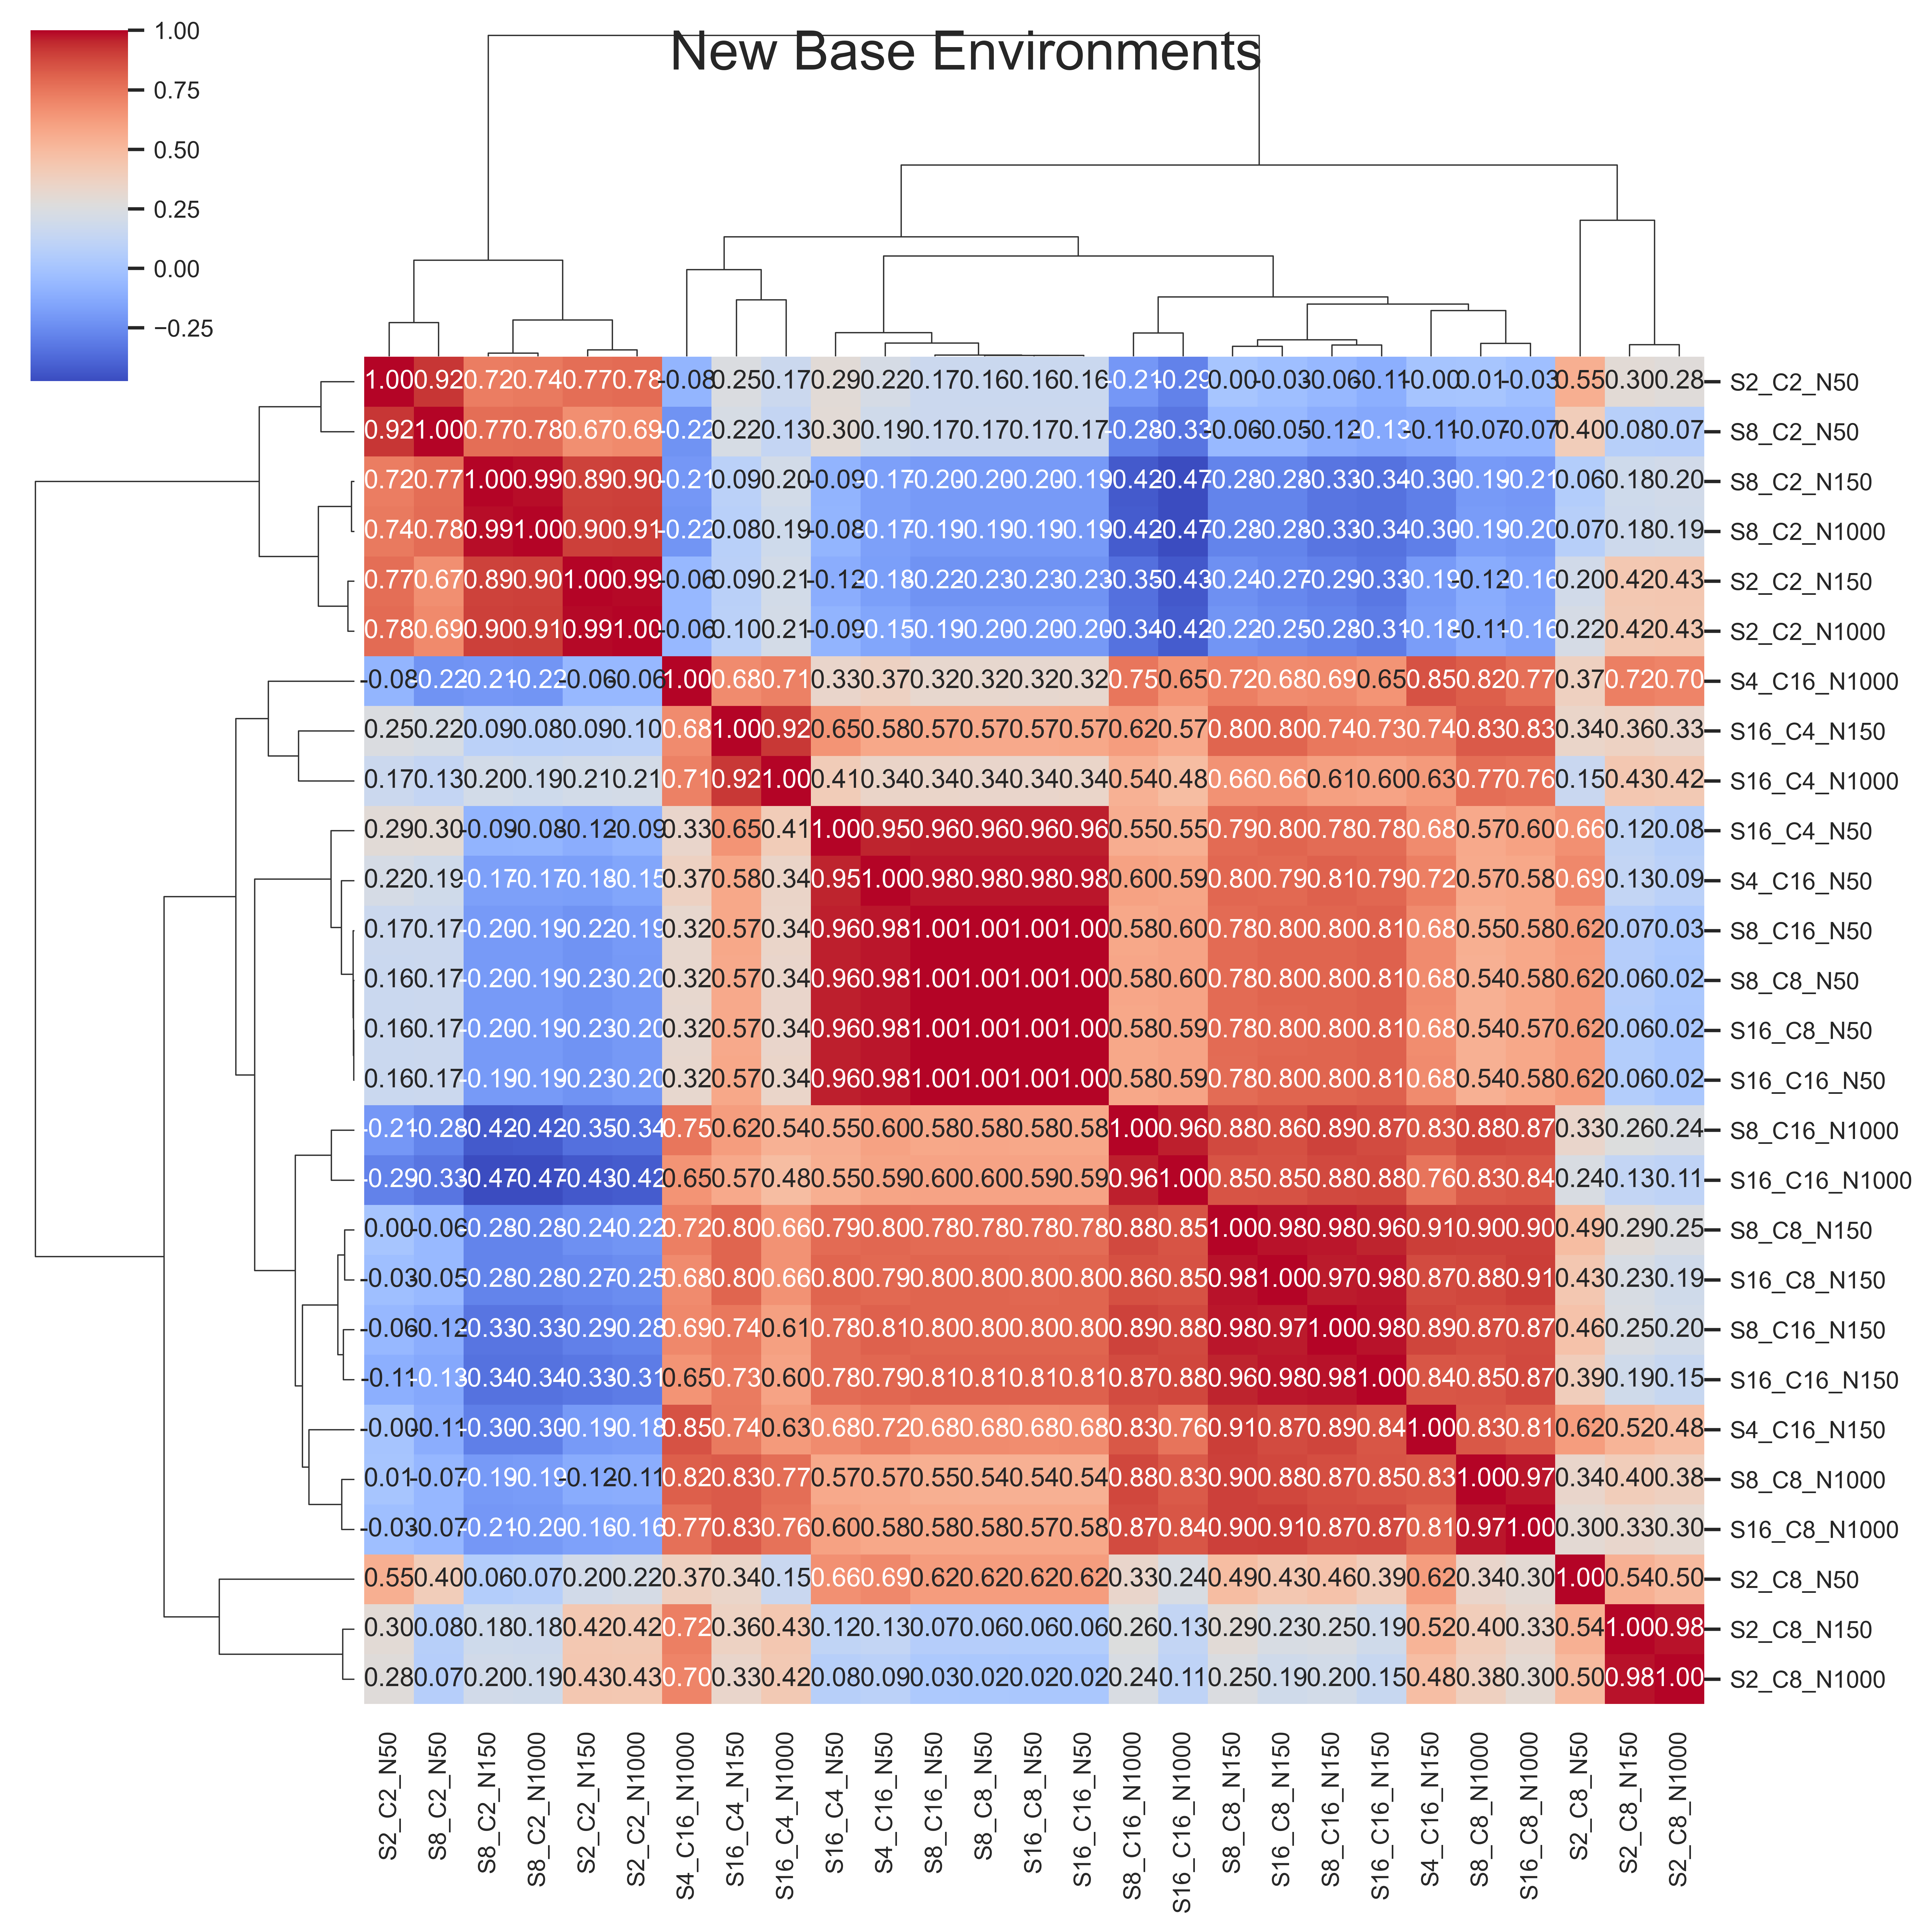

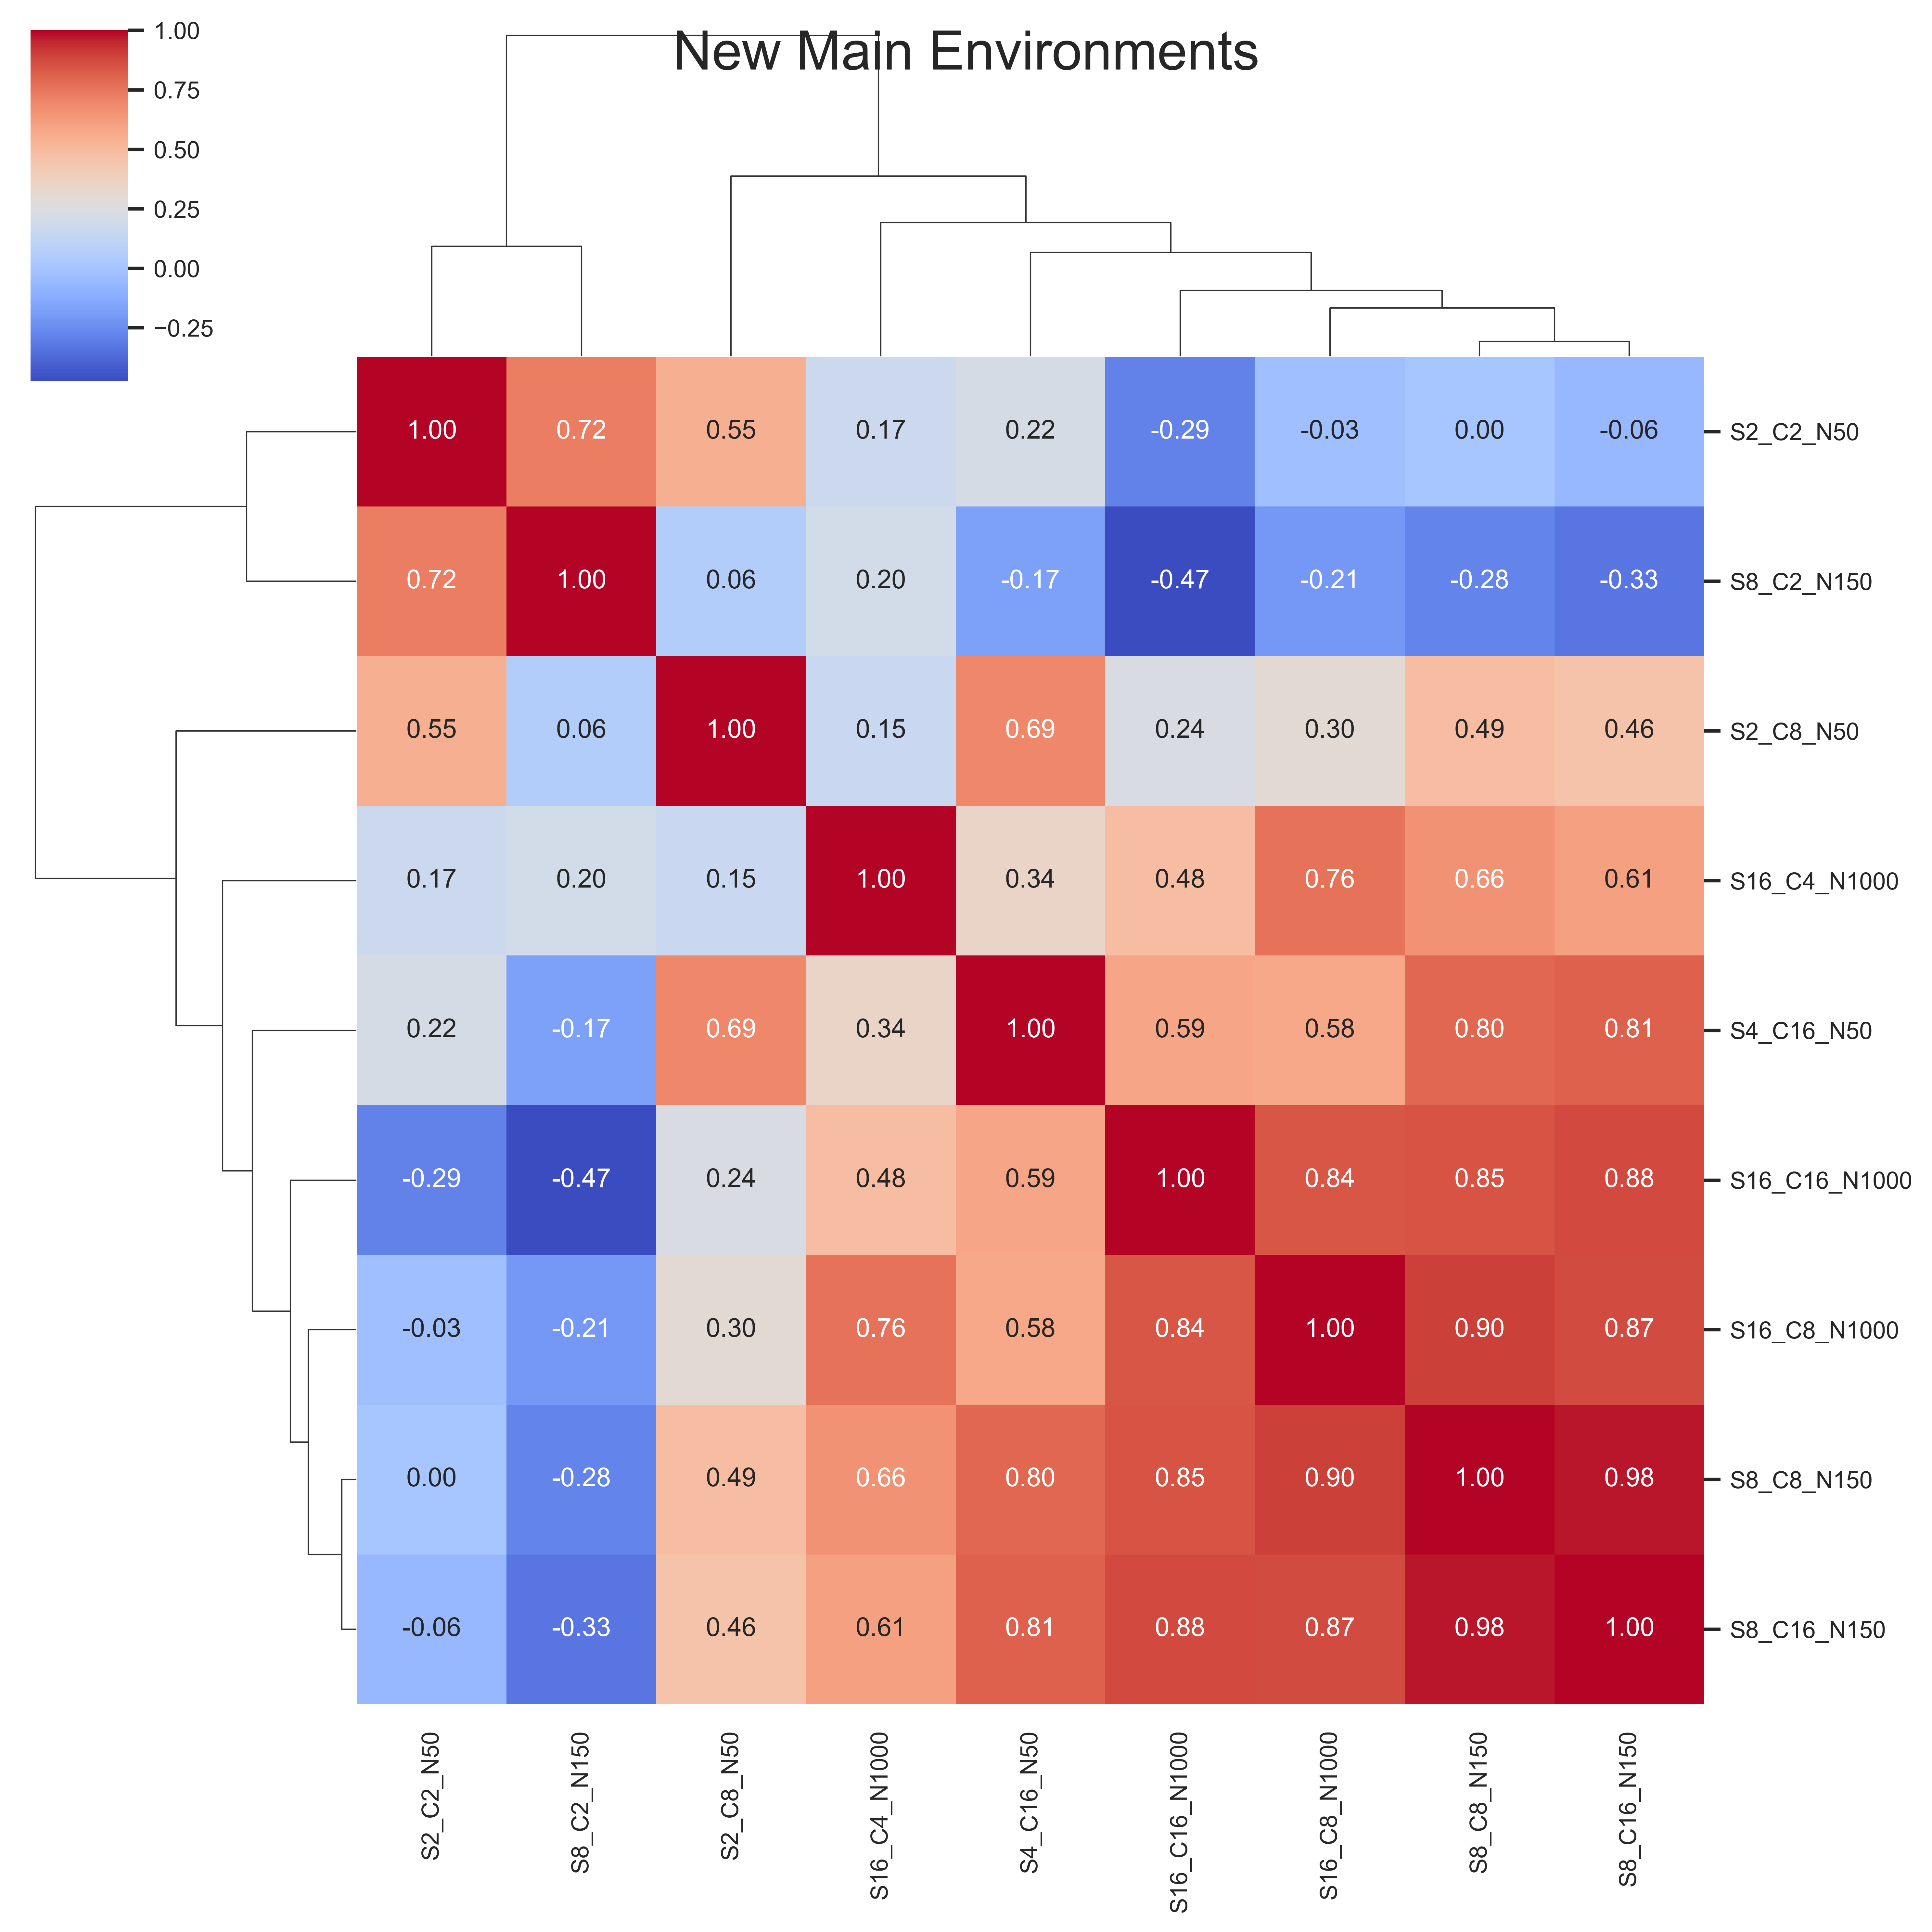

In [8]:
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
plt.rcParams['figure.dpi'] = 600
def get_file_list(base_path, signatures):
    """Generate file lists for the given base path and environment signatures."""
    return [glob.glob(f"{base_path}/{signature}_random_sample*.csv") for signature in signatures]

def load_and_filter_data(file_list, max_config_id, time_threshold=2):
    """Load and filter data based on time and config_id."""
    data_frames = []
    for file in file_list:
        df = pd.read_csv(file)
        df = df[(df['time'] > time_threshold) & (df['config_id'] < max_config_id)]
        data_frames.append(df)
    return pd.concat(data_frames, axis=0, ignore_index=True) if data_frames else pd.DataFrame()

#BASE_PATH = "C:/Users/bened/Desktop/Uni/repos/xdbc-client/experiments/model_optimizer/random_samples_1310k"
BASE_PATH = "C:/Users/bened/Desktop/Uni/repos/xdbc-client/experiments/model_optimizer/random_samples_10_5M"



all_final_base_signatures = ["S2_C2_N50","S2_C8_N50","S4_C16_N50","S8_C8_N50","S8_C2_N50","S8_C16_N50","S16_C4_N50","S16_C8_N50","S16_C16_N50",
                             "S2_C2_N150","S2_C8_N150","S4_C16_N150","S8_C8_N150","S8_C2_N150","S8_C16_N150","S16_C4_N150","S16_C8_N150","S16_C16_N150",
                             "S2_C2_N1000","S2_C8_N1000","S4_C16_N1000","S8_C8_N1000","S8_C2_N1000","S8_C16_N1000","S16_C4_N1000","S16_C8_N1000","S16_C16_N1000"]

all_final_main_signatures = ["S2_C2_N50","S2_C8_N50","S4_C16_N50",
                             "S8_C8_N150","S8_C2_N150","S8_C16_N150",
                             "S16_C4_N1000","S16_C8_N1000","S16_C16_N1000"]

env_lists = {
    "New Base Environments" : all_final_base_signatures,
    "New Main Environments" : all_final_main_signatures,
}

for name, env_list in env_lists.items():
    
    file_lists = get_file_list(BASE_PATH, env_list)
    df_heatmap = pd.DataFrame(0, index=env_list, columns=env_list, dtype=float)
    
    N = 400
    for i, file_list_outer in enumerate(file_lists):
        data_outer = load_and_filter_data(file_list_outer, N)
        for j, file_list_inner in enumerate(file_lists):
            data_inner = load_and_filter_data(file_list_inner, N)
            if not data_outer.empty and not data_inner.empty:
                #df_heatmap.iloc[i, j] = calculate_similarity_wasserstein(data_outer, data_inner)
                df_heatmap.iloc[i, j] = calculate_similarity_spearman(data_outer, data_inner)
                #df_heatmap.iloc[i, j] = calculate_similarity_pearson(data_outer, data_inner)
                #df_heatmap.iloc[i, j] = calculate_similarity_cosine(data_outer, data_inner)
                #df_heatmap.iloc[i, j] = calculate_similarity_euclidian(data_outer, data_inner)
    
    #sns.heatmap(df_heatmap, annot=True)

    '''
    print(f"Sorted columns (index labels) for heatmap '{name}':")
    for column in df_heatmap.columns:
        sorted_index_labels = df_heatmap[column].sort_values(ascending=False).index.tolist()
        print(f"\nColumn: {column}")
        print(sorted_index_labels)
   ''' 

    
    sns.set(font_scale=0.8)
    m = sns.clustermap(
        df_heatmap,
        method="average",
        cmap="coolwarm",
        annot=True,
        fmt=".2f",
        yticklabels=True,
        xticklabels=True
    )
    m.fig.suptitle(name,fontsize=20) 
    #plt.show()
    '''

    distance_matrix = 1 - df_heatmap.to_numpy()

    
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=16, random_state=42)
    cluster_labels = kmeans.fit_predict(distance_matrix)

    # Add cluster labels to a DataFrame
    clustered_df = pd.DataFrame({
        "Environment": env_list,
        "Cluster": cluster_labels
    }).sort_values("Cluster")

    # Perform PCA for visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(distance_matrix)

    # Plot the clusters
    plt.figure(figsize=(10, 6))
    for cluster in range(16):
        cluster_points = reduced_data[cluster_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster + 1}")
    plt.title(f"Clustered Environments ({name})")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()

    # Calculate feature importance from PCA
    components = pca.components_
    explained_variance = pca.explained_variance_ratio_

    # Create a DataFrame for feature contributions
    components_df = pd.DataFrame(
        components.T,
        index=df_heatmap.columns,
        columns=[f"PC{i+1}" for i in range(components.shape[0])]
    )

    # Calculate overall feature importance
    feature_importance = np.sum(np.abs(components.T) * explained_variance, axis=1)
    importance_df = pd.DataFrame({
        "Feature": df_heatmap.columns,
        "Importance": feature_importance
    }).sort_values(by="Importance", ascending=False)

    print(f"Clusters for {name}:")
    print(clustered_df)
    print("\nFeature Importance:")
    print(importance_df)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x="Importance", y="Feature")
    plt.title(f"Feature Importance ({name})")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
    '''

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.stats import wasserstein_distance

def calculate_similarity_cosine(df1, df2):
    # Sort by 'config_id'
    df1_sorted = df1.sort_values(by='config_id').reset_index(drop=True)
    df2_sorted = df2.sort_values(by='config_id').reset_index(drop=True)

    # Align on 'config_id'
    aligned = df1_sorted.merge(df2_sorted, on='config_id', suffixes=('_1', '_2'))
    
    # Extract the 'time' columns
    time1 = aligned['time_1'].values.reshape(1, -1)  # Reshape for cosine similarity
    time2 = aligned['time_2'].values.reshape(1, -1)
    
    # Calculate cosine similarity
    similarity = cosine_similarity(time1, time2)[0, 0]
    return similarity

from scipy.spatial.distance import euclidean

def calculate_similarity_euclidian(df1, df2):
    # Sort and align data as before
    df1_sorted = df1.sort_values(by='config_id').reset_index(drop=True)
    df2_sorted = df2.sort_values(by='config_id').reset_index(drop=True)
    aligned = df1_sorted.merge(df2_sorted, on='config_id', suffixes=('_1', '_2'))

    # Extract the 'time' columns
    time1 = aligned['time_1'].values
    time2 = aligned['time_2'].values

    # Calculate Euclidean distance
    distance = euclidean(time1, time2)
    similarity = 1 / (1 + distance)  # Convert distance to similarity (optional)
    return similarity


def calculate_similarity_pearson(df1, df2):
    # Sort and align data as before
    df1_sorted = df1.sort_values(by='config_id').reset_index(drop=True)
    df2_sorted = df2.sort_values(by='config_id').reset_index(drop=True)
    aligned = df1_sorted.merge(df2_sorted, on='config_id', suffixes=('_1', '_2'))

    # Extract the 'time' columns
    time1 = aligned['time_1'].values
    time2 = aligned['time_2'].values

    # Calculate Pearson correlation
    similarity = np.corrcoef(time1, time2)[0, 1]
    return similarity

from scipy.stats import spearmanr

def calculate_similarity_spearman(df1, df2):
    # Sort and align data as before
    df1_sorted = df1.sort_values(by='config_id').reset_index(drop=True)
    df2_sorted = df2.sort_values(by='config_id').reset_index(drop=True)
    aligned = df1_sorted.merge(df2_sorted, on='config_id', suffixes=('_1', '_2'))

    # Extract the 'time' columns
    time1 = aligned['time_1'].values
    time2 = aligned['time_2'].values

    # Calculate Spearman rank correlation
    similarity, _ = spearmanr(time1, time2)
    return similarity

def calculate_similarity_wasserstein(df1, df2):
    df1_sorted = df1.sort_values(by='config_id').reset_index(drop=True)
    df2_sorted = df2.sort_values(by='config_id').reset_index(drop=True)
    aligned = df1_sorted.merge(df2_sorted, on='config_id', suffixes=('_1', '_2'))

    # Extract the 'time' columns
    time1 = aligned['time_1'].values
    time2 = aligned['time_2'].values
    
    return wasserstein_distance(time1, time2)

 Server  Client  Network
      2       2       20
      8       1       50
      8       8      500
     16       1       10
     16       1     1000
     16       4       10
     16       8      100
     16      16     1000
     16      16    10000
Number of Environments : 16
 Server  Client  Network
      2       2     1000
      2       4     1000
      2       8     1000
      2      16     1000
      4       2     1000
      4       4     1000
      4       8     1000
      4      16     1000
      8       2     1000
      8       4     1000
      8       8     1000
      8      16     1000
     16       2     1000
     16       4     1000
     16       8     1000
     16      16     1000


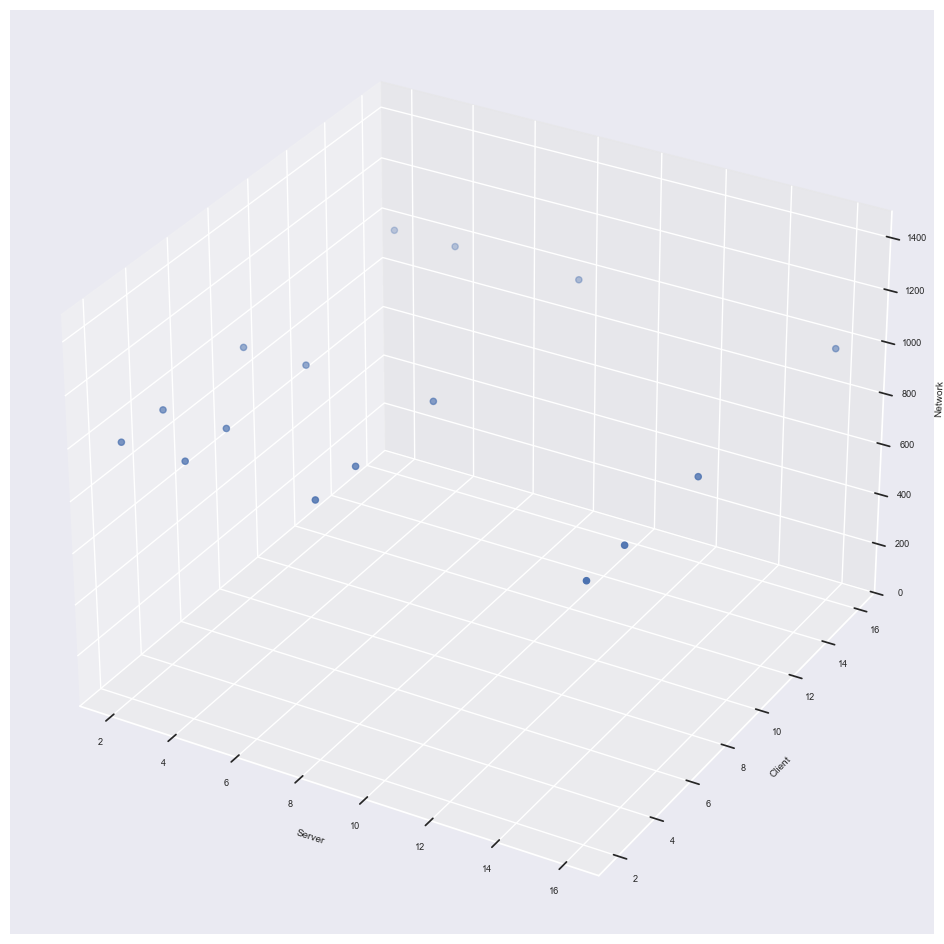

In [37]:
import pandas as pd
import itertools

data = {'Server': [16,16,8,16,16,8,2,16,16],
        'Client': [16,8,1,16,4,8,2,1,1],
        'Network':[1000,100,50,10000,10,500,20,1000,10]}




environments_now = pd.DataFrame(data).sort_values(by=['Server', 'Client', 'Network'],ascending=True)#.reset_index()


print(environments_now.to_string(index=False))

server_values = [2, 4, 8, 16]
client_values = [2, 4, 8, 16]
#network_values = [20, 100, 500, 1000]
network_values = [1000]

# Generate all possible combinations
combinations = list(itertools.product(server_values, client_values, network_values))


print("Number of Environments : " + str(len(combinations)))

environments = pd.DataFrame(combinations, columns=['Server', 'Client', 'Network'])

print(environments.to_string(index=False))



fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(environments.Server,environments.Client,environments.Network)
ax.set_xlabel('Server')
ax.set_ylabel('Client')
ax.set_zlabel('Network')
ax.set_zlim(0, 1500)
plt.show()

In [307]:
'''

environment_1 = {
    "server_cpu": 16,
    "client_cpu": 16,
    "network": 1000,
    "timeout": 250
}

'''

i = 10
for index,row in environments.iterrows():
    '''
    print(f"environment_{i} = " + "{")
    print(f"\"server_cpu\": {row["Server"]},")
    print(f"\"client_cpu\": {row["Client"]},")
    print(f"\"network\": {row["Network"]},")
    print(f"\"timeout\": 150")
    print("}")
    '''
    #print(f"environment_{i},", end="")
    #print(f"file_list_env_{i} = glob.glob('C:/Users/bened/Desktop/Uni/repos/xdbc-client/experiments/model_optimizer/random_samples_1310k/S{row["Server"]}_C{row["Client"]}_N{row["Network"]}_random_sample*.csv')")

    #print(f"\"S{row["Server"]}_C{row["Client"]}_N{row["Network"]}\",", end="")
    #print(f"file_list_env_{i},",end="")

    #print(f"env_S{row["Server"]}_C{row["Client"]}_N{row["Network"]} = environment_{i}")


    i = i+1
    